In [110]:
import os
import sys
import csv

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

import statsmodels.stats.multitest as multi

import random

%matplotlib inline

In [111]:
def build_snp_maf_dict(gcount_directory, snp2maf = None):
    # gcount files, one per chromosome
    gcount_files = [f for f in os.listdir(gcount_directory) if f.endswith('gcount')]
    
    if snp2maf is None:
        snp2maf = dict()
    elif type(snp2maf) != dict:
        raise Exception("Provided snp2maf parameter must be dict type.")
    
    for gcount_file in gcount_files:

        fh = open(os.path.join(os.path.join(gcount_directory, gcount_file)))
        reader = csv.reader(fh, delimiter='\t')
        next(reader)

        for row in reader:
            rsid = row[1]
            AA = int(row[4])
            AB = int(row[5])
            BB = int(row[6])

            maf = min((2*AA+AB)/(2*AA+AB+2*BB), (2*BB+AB)/(2*AA+AB+2*BB))

            snp2maf[rsid] = {
                'maf': maf,
                'AA': AA,
                'AB': AB,
                'BB': BB
            }

        fh.close()

    return snp2maf


In [125]:
studies = [
    {
        'name': 'gs2:apr_pos_severe',
        'prefix': 'apr_pos_severe',
        'dir': 'gene_set_2',
        'alpha': 0.001,
        'max_distance': 60000,
    },
    {
        'name': 'gs2:may_pos_severe',
        'prefix': 'may_pos_severe',
        'dir': 'gene_set_2',
        'alpha': 0.0025,
        'max_distance': 60000,
    },
    {
        'name': 'ld:apr_pos_severe',
        'prefix': 'apr_pos_severe',
        'dir': 'gene_set_ld',
        'alpha': 0.01,
        'max_distance': 60000,
    },
    {
        'name': 'ld:may_pos_severe',
        'prefix': 'may_pos_severe',
        'dir': 'gene_set_ld',
        'alpha': 0.0075,
        'max_distance': 60000,
    }
]

plink_results_file = 'data/ukbb/%(dir)s/%(prefix)s.PHENO1.glm.logistic.adjusted'
plink_details_file = 'data/ukbb/%(dir)s/%(prefix)s.PHENO1.glm.logistic'

study_gcount_directory = 'data/ukbb/%(dir)s/%(prefix)s_gcount'
all_gcount_directories = ('data/ukbb/gene_set_2/ukb_all_gcount',
                          'data/ukbb/gene_set_ld/all_ukb')

distances_file = 'data/ukbb/gene_set_2/05172020_snps_gene_distance.txt'
ld_distances_file = 'data/ukbb/gene_set_ld/05242020_snps_gene_distance.txt'

In [126]:
# load the genotype frequencies
all_snp2maf = dict()
for all_gcount_directory in all_gcount_directories:
    all_snp2maf = build_snp_maf_dict(all_gcount_directory, all_snp2maf)

study_snp2maf = dict()
for study in studies:
    study_snp2maf[study['name']] = build_snp_maf_dict(study_gcount_directory % study)

In [127]:
for study in studies:
    print(study['name'], min([d['maf'] for r, d in study_snp2maf[study['name']].items()]))

gs2:apr_pos_severe 0.0015082956259426848
gs2:may_pos_severe 0.002036659877800407
ld:apr_pos_severe 0.0015082956259426848
ld:may_pos_severe 0.002036659877800407


In [128]:
# load the association study detailed results for the study
minimum_maf = 0.01

study2plink_details = dict()
study2plink_results = dict()

for study in studies:

    fh = open(plink_details_file % study)
    reader = csv.reader(fh, delimiter='\t')
    header = next(reader)

    plink_details = dict()
    plink_results = list()

    for row in reader:
        if row[0][0] == '#':
            continue

        row = dict(zip(header, row))
        if row['TEST'] == 'ADD':
            plink_details[row['ID']] = row
            if (not row['ID'] in all_snp2maf) or (all_snp2maf[row['ID']]['maf'] >= minimum_maf): 
                plink_results.append([row['#CHROM'], row['ID'], row['A1'], float(row['P'])])

    print(study['name'], len(plink_details), len(plink_results))
    study2plink_details[study['name']] = plink_details
    study2plink_results[study['name']] = plink_results
    
    del plink_details
    del plink_results

gs2:apr_pos_severe 3562 3540
gs2:may_pos_severe 3562 3540
ld:apr_pos_severe 942 936
ld:may_pos_severe 942 936


In [129]:
# load the rsid to gene mappings
fh = open(distances_file)
reader = csv.reader(fh, delimiter='\t')
header = next(reader)

rsid2gene = dict()
rsid2distance = dict()

for rsid, closest_gene, distance_to_gene in reader:
    rsid2gene[rsid] = closest_gene
    rsid2distance[rsid] = int(distance_to_gene)

fh.close()

# load the rsid to gene mappings
fh = open(ld_distances_file)
reader = csv.reader(fh, delimiter='\t')
header = next(reader)

for rsid, closest_gene, distance_to_gene in reader:
    rsid2gene[rsid] = closest_gene
    rsid2distance[rsid] = int(distance_to_gene)
fh.close()

In [130]:
for study in studies:
    snps = [row[1] for row in study2plink_results[study['name']]]
    
    print(study['name'], 
          study['max_distance'],
          len([rsid for rsid in snps if rsid2distance[rsid] < study['max_distance']]),
          len(set([rsid2gene[rsid] for rsid in snps]))
    )

gs2:apr_pos_severe 60000 2888 97
gs2:may_pos_severe 60000 2888 97
ld:apr_pos_severe 60000 936 92
ld:may_pos_severe 60000 936 92


In [105]:
# for study in studies:
#     print(study['name'])
#     unadjusted = [row[3] for row in study2plink_results[study['name']]]
#     break

## Pull out and build a table from the study-wide significant hits

In [106]:
union_hits = set()
union_all = set()

for study in studies:
    print(study['name'])
    for chrom, rsid, allele, unadjusted in study2plink_results[study['name']]:
        union_all.add(rsid)
        if unadjusted < study['alpha'] and rsid2distance[rsid] < study['max_distance']:
            print(rsid, chrom, allele, unadjusted, all_snp2maf[rsid]['maf'], sep='\t')
            union_hits.add(rsid)
        
#         if rsid in ('rs28752969','rs28367802','rs28752965','rs28752966','rs28752967','rs28367809','rs28367810','rs28752936','rs28367816','rs28752909','rs28380804','rs28752975','rs28367804','rs28752920','rs28752956','rs28752971','rs28752972','rs28753066','rs28752894','rs28752895','rs28752893','rs28367786','rs28367791','rs28367790','rs28752896','rs28752970','rs28752917','rs28752915','rs28752959','rs28367797','rs28771384','rs28752931','rs28367785','rs28367860','rs28752877','rs28752878','rs28752879','rs113534555','rs28753052','rs4401661','rs4257854','rs28752980','rs28752928','rs28771380','rs28753057','rs28367817','rs28367819','rs12665338','rs28752977','rs28752960','rs28752962','rs28753049','rs28367821','rs28367822','rs28752938','rs28367831','rs28367832','rs28752978','rs28752979','rs28752981','rs28752952','rs28752937','rs28752929','rs28752941','rs28752939','rs28367792','rs113141328','rs28752932','rs28367811','rs111729358','rs28367825','rs28367824','rs28367826','rs28367827','rs28367828','rs28367793','rs28752955','rs28752953','rs28752945','rs28752944','rs28752923','rs28752922','rs28752921','rs28752948','rs28752949','rs28752904','rs28752905','rs28752903','rs28752900','rs28752901','rs28752902','rs28752899','rs28752898','rs28752882','rs28752881','rs28752880','rs28752885','rs28752884','rs28367781','rs28752983','rs28752984','rs28752985','rs28752986','rs12665374','rs28752973','rs28752924','rs28367815','rs28752975','rs28752965','rs28752966','rs28752967','rs28367802','rs28367815','rs28752959','rs28380804','rs28753066','rs28367816','rs28752923','rs28752922','rs28752921','rs28752920','rs28367791','rs28367790','rs28752904','rs28752905','rs28752903','rs28752900','rs28752901','rs28752902','rs28752899','rs28752898','rs28771384','rs28752931','rs28367785','rs28367860','rs28752877','rs28752878','rs28752879','rs28752894','rs113534555','rs28752895','rs28752893','rs28752971','rs28752972','rs28753052','rs4401661','rs4257854','rs28367786','rs28752980','rs28752928','rs28771380','rs28753057','rs28367817','rs28367819','rs12665338','rs28752977','rs28367804','rs28752962','rs28752917','rs28753049','rs28367821','rs28367822','rs28752938','rs28752896','rs28367831','rs28752970','rs28367832','rs28752978','rs28752956','rs28752979','rs28752981','rs28752952','rs28752937','rs28752929','rs28752941','rs28752909','rs28752939','rs28367792','rs113141328','rs28752932','rs28367811','rs111729358','rs28367825','rs28367824','rs28367826','rs28367827','rs28367828','rs28367793','rs28752955','rs28752953','rs28752915','rs28752945','rs28752944','rs28752949','rs28752948','rs28367809','rs28367810','rs28367797','rs12665374','rs28752983','rs28752984','rs28752985','rs28752986','rs28752882','rs28752881','rs28752880','rs28752885','rs28752884','rs28367781','rs28752960','rs28752936','rs28752969','rs28752973','rs28752924'):
#             print(rsid, chrom, allele, unadjusted, all_snp2maf[rsid]['maf'], sep='\t')
len(union_all), len(union_hits)

gs2:apr_pos_severe
rs117284601	11	A	0.000106022	0.042371861157841126
rs9913923	17	T	0.000558963	0.10391603400168711
rs2230203	19	T	0.000256514	0.22603438138947146
rs1047286	19	A	0.000101855	0.25711402587631643
rs2230199	19	C	0.000391917	0.25488521049673085
rs72729504	1	T	0.000424132	0.024386022182914146
rs12064775	1	G	0.000370689	0.016885728845347833
rs45574833	1	A	1.19866e-05	0.012392457339472265
rs61821041	1	G	0.00027397	0.012679706763010815
rs61821114	1	T	3.94457e-05	0.015024298035839791
rs3024329	6	G	0.00098824	0.12086316280567337
gs2:may_pos_severe
rs78958998	11	T	0.00108146	0.10330131536910934
rs117284601	11	A	0.000210471	0.042371861157841126
rs669	12	C	0.000654354	0.4524828627504398
rs10842898	12	T	0.000850372	0.4568644062912438
rs7297589	12	A	0.00118078	0.5634910661692519
rs61916033	12	G	0.00146097	0.10162895370427377
rs4883215	12	G	0.000453652	0.4189209482334201
rs117316516	12	C	0.000933031	0.019573389189263136
rs74504130	12	A	0.000860454	0.06001309946505295
rs9913923	17	T	0.0

(3543, 38)

In [107]:
gt_types = ['maf', 'AA', 'AB', 'BB']

for study in studies:
    print(study)
    ofh = open('results/r1/table3_ukbb_results_%(name)s.csv' % study, 'w')
    writer = csv.writer(ofh)

    sig_chroms = set()

    results_header = ["rsid", "chrom", "pos", "ref", "alt", "OR", "log(OR)se", "z_stat", "allele", "unadjusted", "gene", "distance_from_gene"] + gt_types + gt_types 
    writer.writerow(results_header)

    for chrom, rsid, allele, unadjusted in study2plink_results[study['name']]:
        details = study2plink_details[study['name']][rsid]
        genotype_counts = [all_snp2maf[rsid][k] for k in gt_types]
        genotype_counts += [study_snp2maf[study['name']][rsid][k] for k in gt_types]

        if unadjusted < study['alpha'] and rsid2distance[rsid] < study['max_distance']:
            writer.writerow([rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, rsid2gene[rsid], rsid2distance[rsid]] + genotype_counts)
            print(rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, rsid2gene[rsid])
            sig_chroms.add(int(chrom))

    ofh.close()

{'name': 'gs2:apr_pos_severe', 'prefix': 'apr_pos_severe', 'dir': 'gene_set_2', 'alpha': 0.001, 'max_distance': 60000}
rs117284601 11 57425228 A G 1.80043 0.151694 3.87638 A 0.000106022 SERPING1
rs9913923 17 1703982 T C 1.48131 0.113865 3.45078 T 0.000558963 SERPINF2
rs2230203 19 6710782 T G 0.660121 0.113613 -3.65567 T 0.000256514 C3
rs1047286 19 6713262 A G 0.656802 0.108173 -3.88613 A 0.000101855 C3
rs2230199 19 6718387 C G 0.684134 0.107067 -3.54547 C 0.000391917 C3
rs72729504 1 94940206 T C 1.93339 0.18705 3.52459 T 0.000424132 F3
rs12064775 1 196600605 G A 2.13153 0.212588 3.56012 G 0.000370689 CFH
rs45574833 1 207300070 A G 2.64776 0.222419 4.37783 A 1.19866e-05 C4BPA
rs61821041 1 207352581 G A 2.3377 0.233369 3.63874 G 0.00027397 C4BPA
rs61821114 1 207610967 T C 2.39526 0.212492 4.1107 T 3.94457e-05 CR2
rs3024329 6 6316135 G T 1.43224 0.109063 3.29385 G 0.00098824 F13A1
{'name': 'gs2:may_pos_severe', 'prefix': 'may_pos_severe', 'dir': 'gene_set_2', 'alpha': 0.0025, 'max_distanc

## Table 2. Summary of Candidate Gene Study Results

The new Table 2 for the revision will contain a summary of all of the candidate gene study results. This includes the results of the original analysis (gs2 apr), an repeat of that analysis with updated phenotype data (gs2 may), an alternative SNP selection method based on LD with the study genes (LD apr) and its udpated phenotype data counterpart (LD may). 

In [109]:
# out_filename = 'results/r1/table2_ukbb_results_union.csv'
# union_set = union_hits

out_filename = 'results/r1/table2_ukbb_results_union_all.csv'
union_set = union_all

gt_types = ['maf', 'AA', 'AB', 'BB']

ofh = open(out_filename, 'w')
writer = csv.writer(ofh)

results_header = ["rsid", "chrom", "pos", "gene", "distance_from_gene", "ref", "alt"] \
    + ["%(name)s_%(alpha)s" % s for s in studies] \
    + list(map(lambda x: "all_%s" % x, gt_types)) \
    + ["apr_OR", "apr_log(OR)se", "apr_z_stat", "apr_allele", "apr_unadjusted"] \
    + list(map(lambda x: "apr_%s" % x, gt_types)) \
    + ["may_OR", "may_log(OR)se", "may_z_stat", "may_allele", "may_unadjusted"] \
    + list(map(lambda x: "may_%s" % x, gt_types))

writer.writerow(results_header)

for rsid in union_set:
    
    # the association statistics are not dependant on the study (gs2 vs ld), so 
    # we try with gs2 first and if not available then we use ld
    if rsid in study2plink_details['gs2:apr_pos_severe']:
        apr_details = study2plink_details['gs2:apr_pos_severe'][rsid]
        apr_gt_counts = [study_snp2maf['gs2:apr_pos_severe'][rsid][k] for k in gt_types]
    else:
        apr_details = study2plink_details['ld:apr_pos_severe'][rsid]
        apr_gt_counts = [study_snp2maf['ld:apr_pos_severe'][rsid][k] for k in gt_types]
    
    if rsid in study2plink_details['gs2:may_pos_severe']:
        may_details = study2plink_details['gs2:may_pos_severe'][rsid]
        may_gt_counts = [study_snp2maf['gs2:may_pos_severe'][rsid][k] for k in gt_types]
    else:
        may_details = study2plink_details['ld:may_pos_severe'][rsid]
        may_gt_counts = [study_snp2maf['ld:may_pos_severe'][rsid][k] for k in gt_types]
    
    all_gt_counts = [all_snp2maf[rsid][k] for k in gt_types]
    
    # add common elements
    row = [rsid, apr_details['#CHROM'], apr_details['POS'], 
           rsid2gene[rsid], rsid2distance[rsid], 
           apr_details['REF'], apr_details['ALT']]
    
    # add significance indicators
    siglist = list()
    for study in studies:
        if not rsid in study2plink_details[study['name']]:
            siglist.append('N/A')
        elif float(study2plink_details[study['name']][rsid]['P']) < study['alpha']:
            siglist.append('Yes')
        else:
            siglist.append('No')
    
    row += siglist
    
    # add all genotype counts
    row += all_gt_counts
    
    # add apr only elements
    row += [apr_details['OR'], apr_details['LOG(OR)_SE'], apr_details['Z_STAT'], apr_details['A1'], apr_details['P']]
    row += apr_gt_counts
    
    # add may only elements
    row += [may_details['OR'], may_details['LOG(OR)_SE'], may_details['Z_STAT'], may_details['A1'], may_details['P']]
    row += may_gt_counts
    
    #print(*row, sep=' ')

    writer.writerow(row)

ofh.close()

In [25]:
def get_effect_vectors(snp_set):
    apr_betas = list()
    may_betas = list()
    
    for rsid in snp_set:
        if not rsid in study2plink_details['gs2:apr_pos_severe']:
            continue
        apr_details = study2plink_details['gs2:apr_pos_severe'][rsid]
        may_details = study2plink_details['gs2:may_pos_severe'][rsid]

        apr_beta = np.log(float(apr_details['OR']))
        may_beta = np.log(float(may_details['OR']))

        apr_betas.append(apr_beta)
        may_betas.append(may_beta)
    
    return apr_betas, may_betas

In [26]:
fit_params = list()
r_values = list()
for i in range(1000):
    sample_hits = random.sample(union_all, len(union_hits))
    apr_betas, may_betas = get_effect_vectors(sample_hits)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(apr_betas, may_betas)
    r_values.append(r_value)
    fit_params.append((slope, intercept, r_value, p_value, std_err))

len(r_values), len([r for r in r_values if r > 0.93706])

(1000, 22)

In [31]:
np.mean(r_values)

0.8168702300314875

In [ ]:
apr_betas, may_betas = get_effect_vectors(union_hits)

for slope, intercept, r_value, p_value, std_err in fit_params:
    x = np.arange(min(apr_betas), max(apr_betas), 0.01)
    y = x*slope + intercept
    plt.plot(x, y, 'g-', alpha=0.01)

slope, intercept, r_value, p_value, std_err = stats.linregress(apr_betas, may_betas)
print(r_value)
plt.scatter(apr_betas, may_betas, color='k')


x = np.arange(min(apr_betas), max(apr_betas), 0.01)
y = x*slope + intercept
plt.plot(x, y, 'k-')

sns.despine()

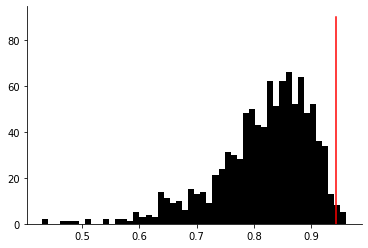

In [33]:
plt.hist(r_values, bins=50, color='k')
plt.plot([r_value, r_value], [0, 90], 'r-')
sns.despine()

## Build mini-Manhattan plots

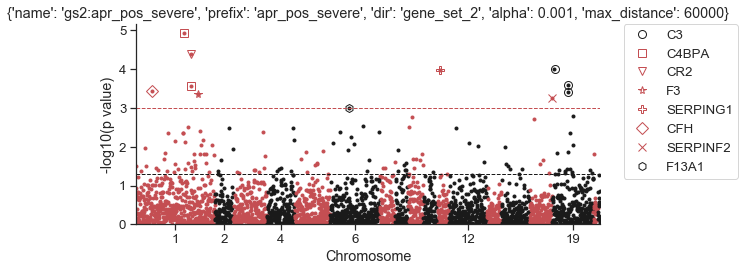

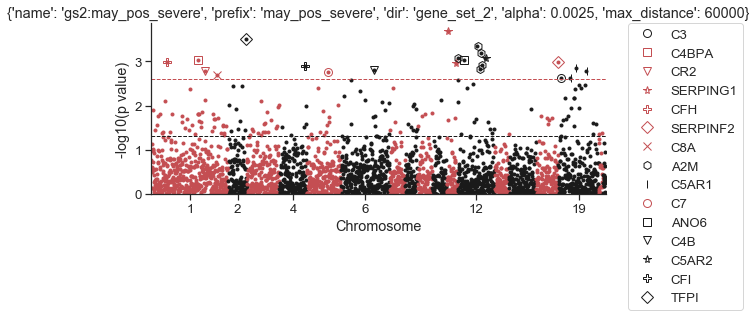

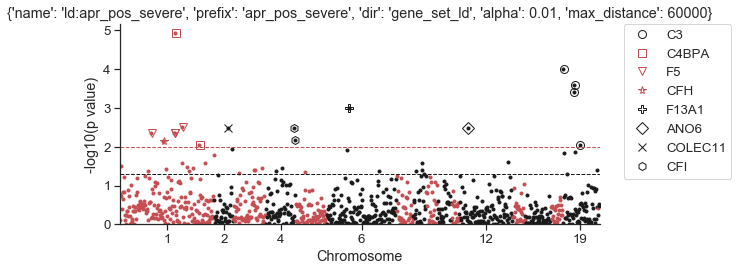

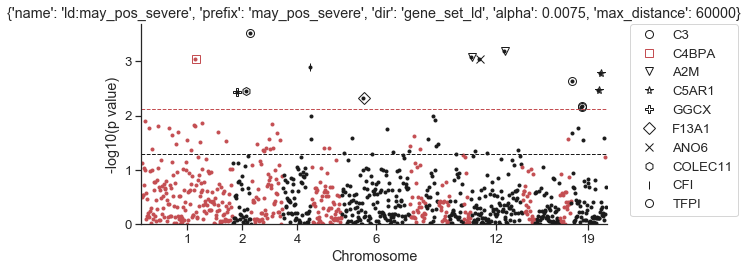

In [34]:
for study in studies:

    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(10,4))

    neglog10 = lambda p: -1*np.log10(p)

    chromosomes = sorted(set(map(int,list(zip(*study2plink_results[study['name']]))[0])))

    start_pos = 0
    alternate = 0
    tick_positions = list()
    tick_labels = list()

    gene_markers = list()
    sig_genes = set()
    
    for this_chrom in chromosomes:

        unadjusted_pvalues = list()

        for chrom, rsid, allele, unadjusted in sorted(study2plink_results[study['name']]):
            if int(chrom) != this_chrom:
                continue
            
            if rsid2distance[rsid] > study['max_distance']:
                continue
            
            unadjusted_pvalues.append(neglog10(unadjusted))

            if unadjusted < study['alpha']:
                gene_markers.append((rsid2gene[rsid], len(unadjusted_pvalues)+start_pos, unadjusted, alternate))
                sig_genes.add(rsid2gene[rsid])

        fmt = 'k.'
        if alternate % 2 == 0:
            fmt = 'r.'

        plt.plot(range(start_pos, start_pos+len(unadjusted_pvalues)) ,unadjusted_pvalues, fmt)

        if this_chrom in sig_chroms:
            tick_positions.append(len(unadjusted_pvalues)/2+start_pos)
            tick_labels.append(this_chrom)

        start_pos += len(unadjusted_pvalues)
        alternate += 1

    # plot the significant genes
    markerstyles = ['o', 's', 'v', '*', 'P', 'D', 'x', 'h', '|']
    legend_names = list()
    for i, gene in enumerate(sig_genes):
        _, xpos, unadj, alternate = zip(*[(g,x,p,a) for g,x,p,a in gene_markers if g == gene])

        color = 'k'
        if alternate[0] % 2 == 0:
            color = 'r'
        plt.plot(xpos, list(map(neglog10,unadj)), lw=0, color='none', markeredgecolor=color, markersize=8, marker=markerstyles[i%len(markerstyles)], label=gene)
        legend_names.append(gene)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    # Add some markers for where the significance threshold is
    # and customize the tick marks and labels
    un_alpha = neglog10(0.05)
    bh_alpha = neglog10(study['alpha'])
    
    plt.plot([0, len(study2plink_results[study['name']])], [un_alpha, un_alpha], 'k--', lw=1)
    plt.plot([0, len(study2plink_results[study['name']])], [bh_alpha, bh_alpha], 'r--', lw=1)
    plt.xlim(0, start_pos)
    plt.ylim(0)
    plt.ylabel('-log10(p value)')

    plt.xticks(tick_positions, tick_labels)
    plt.xlabel('Chromosome')

    plt.title(study)

    sns.despine()
    plt.tight_layout()

    plt.savefig('figures/r1/ukbb_complwas_%s.pdf' % study['name'])

## QQ Plots

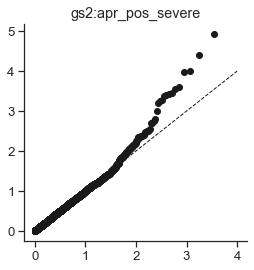

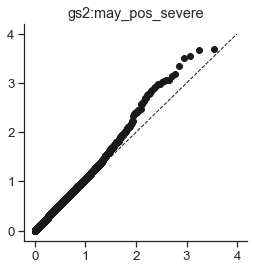

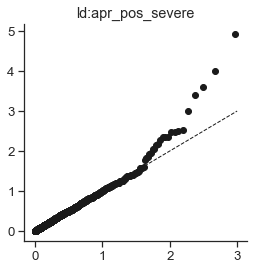

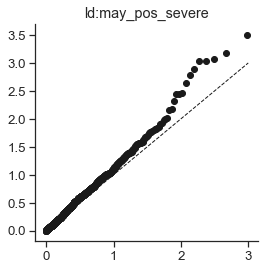

In [72]:
for study in studies:
    observed = sorted([-np.log10(float(snp['P'])) for rsid, snp in study2plink_details[study['name']].items()])
    expected = sorted(-np.log10(np.arange(1/len(observed), 1, (1-1/len(observed))/len(observed))))

    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(4,4))
    plt.title(study['name'])
    plt.scatter(expected, observed, marker='o', color='k')
    plt.plot(np.arange(0, max(expected)+1), np.arange(0, max(expected)+1), 'k--', lw=1)
    sns.despine()
    
    plt.savefig('figures/r1/ukbb_complwas_qqplot_%s.pdf' % study['name'])
